In [38]:
import pandas as pd            
import numpy as np             
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [3]:
# Read csv
df = pd.read_csv('CrowdstormingDataJuly1st.csv')
# Drop meaningless columns, we don't need the whole player name nor the birthday
df.drop(['player','birthday'], 1, inplace=True)
# Drop dyads where there are no photoID
df.dropna(axis=0, subset=['photoID'], inplace=True)
df.drop('photoID', 1, inplace=True)
# Drop dyads where there are no rating
df.dropna(axis=0, how='all', subset=['rater1', 'rater2'], inplace=True)

In [4]:
# First, try without 'racist data'
df.drop(['refNum','refCountry','Alpha_3','meanIAT','nIAT','seIAT','meanExp','nExp','seExp'], 1, inplace=True)

In [5]:
# Need to sum for the aggregation
sumAggIndexes = ['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
dfSumAgg = df[sumAggIndexes]
aggregatedWithSum = dfSumAgg.groupby('playerShort').sum()

# No sum for aggregation
dfIdentityAgg = df[['playerShort', 'club', 'leagueCountry', 'height', 'weight',
       'position', 'rater1', 'rater2']]
identity = lambda x: x.iloc[0]
aggregatedWithIdentity = dfIdentityAgg.groupby('playerShort').agg(identity)

# Concatenate
dfd = pd.concat([aggregatedWithIdentity, aggregatedWithSum], axis=1)


In [6]:
# Normalize:

# vitories, defeats, ties, goals, cards -> 
#   for each player x: x._/x.games

colsToNorm = ['victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards']
ds = []
for c in colsToNorm:
    col = []
    for i in dfd.index:
        col.append(dfd[c].loc[i]/dfd['games'].loc[i])
    ds.append(pd.DataFrame(columns=[c], index=dfd.index, data=col))
 
# Normalize the games column
colsToNorm.append('games')
meanGames = dfd['games'].mean()
stdGames = dfd['games'].std()

ds.append(pd.DataFrame(columns=['games'], index=dfd.index, data=dfd['games'].map(lambda x : (x-meanGames)/stdGames)))

dfd = pd.concat([pd.concat(ds,axis=1), dfd.drop(colsToNorm, axis=1)] ,axis=1)

In [7]:
# Deal with NaN in weight and height
# There are only few missing data so we can fill them with the mean of the column without
# inducing to much bias in the data

ws = dfd['weight']
meanW = ws.dropna().mean()
dfd['weight'].fillna(meanW, inplace=True)

hs = dfd['height']
meanH = hs.dropna().mean()
dfd['height'].fillna(meanH, inplace=True)

In [33]:
diff = abs(dfd['rater1']-dfd['rater2'])
diff.value_counts()
# rm outliers
dfd.drop(diff[diff == 0.50].index, inplace=True)

In [34]:
meanColor = (dfd['rater1']+dfd['rater2'])/2

# This is the target/observation
target = meanColor
# This is the data
data = dfd.drop(['rater1', 'rater2'], axis=1)
data.head()

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games,club,leagueCountry,height,weight,position
playerShort,,,,,,,,,,,,,
aaron-hughes,0.377676,0.273700,0.348624,0.013761,0.029052,0.000000,0.000000,2.935828,Fulham FC,England,182.0,71.0,Center Back
aaron-hunt,0.419643,0.217262,0.363095,0.184524,0.125000,0.000000,0.002976,0.705694,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder
aaron-lennon,0.485437,0.235437,0.279126,0.075243,0.026699,0.000000,0.000000,1.238682,Tottenham Hotspur,England,165.0,63.0,Right Midfielder
aaron-ramsey,0.576923,0.161538,0.261538,0.150000,0.119231,0.000000,0.003846,0.172706,Arsenal FC,England,178.0,76.0,Center Midfielder
abdelhamid-el-kaoutari,0.330645,0.322581,0.346774,0.008065,0.064516,0.032258,0.016129,-0.781062,Montpellier HSC,France,180.0,73.0,Center Back


In [65]:
# skin color
#colors = np.array([0, 0.25, 0.5, 0.75, 1])
#def find_nearest(array,value):
#    idx = (np.abs(array-value)).argmin()
#    return array[idx]
#
#meanColor = (dfd['rater1']+dfd['rater2'])/2
#
## This is the target/observation
#target = meanColor.apply(lambda x: find_nearest(colors, x)).astype('str')
## This is the data
#data = dfd.drop(['rater1', 'rater2'], axis=1)
#data.head()

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games,club,leagueCountry,height,weight,position
playerShort,,,,,,,,,,,,,
aaron-hughes,0.377676,0.273700,0.348624,0.013761,0.029052,0.000000,0.000000,2.935828,Fulham FC,England,182.0,71.0,Center Back
aaron-hunt,0.419643,0.217262,0.363095,0.184524,0.125000,0.000000,0.002976,0.705694,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder
aaron-lennon,0.485437,0.235437,0.279126,0.075243,0.026699,0.000000,0.000000,1.238682,Tottenham Hotspur,England,165.0,63.0,Right Midfielder
aaron-ramsey,0.576923,0.161538,0.261538,0.150000,0.119231,0.000000,0.003846,0.172706,Arsenal FC,England,178.0,76.0,Center Midfielder
abdelhamid-el-kaoutari,0.330645,0.322581,0.346774,0.008065,0.064516,0.032258,0.016129,-0.781062,Montpellier HSC,France,180.0,73.0,Center Back


In [35]:
# Encode the categorical features
le = preprocessing.LabelEncoder()
clubEncoded = pd.Series(index=data.index, data=le.fit_transform(data.club))
leagueCountryEncoded = pd.Series(index=data.index, data=le.fit_transform(data.leagueCountry))
# Encode the 'position', it has NaN values, so we handle them by replacing them
# by the most frequent label
position = data['position']
posFiltered = position.dropna()
posNan = position[position.isnull()]
posFilEnc = le.fit_transform(posFiltered)
posFilEncAsSerie = pd.Series(index=posFiltered.index, data=posFilEnc)
concat = pd.concat([posFilEncAsSerie, posNan])
positionWithNan = concat.sort_index()

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)
positionEncoded = pd.Series(index=positionWithNan.index, data=imp.fit_transform(positionWithNan)[0].astype(int))

# Dataframe with categorical data encoded as int
dataEncoded = pd.concat([clubEncoded, positionEncoded, leagueCountryEncoded],axis=1)
dataEncoded.columns = ['club', 'position', 'leagueCountry']

C:\Users\bapti\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [36]:
# One hot encoder
enc = preprocessing.OneHotEncoder()
enc.fit(dataEncoded)
oneHotEncodedData = enc.transform(dataEncoded).toarray()
#oneHotEncodedData.astype()
dfEncoded = pd.DataFrame(index=dataEncoded.index, data=oneHotEncodedData).astype(int)

In [37]:
# New data with categorical data encoded
dff = pd.concat([data.drop(['club','position','leagueCountry'], axis=1), dfEncoded], axis=1)
dff.head(2)

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,games,height,weight,...,103,104,105,106,107,108,109,110,111,112
playerShort,,,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.377676,0.273700,0.348624,0.013761,0.029052,0.0,0.000000,2.935828,182.0,71.0,...,0,0,0,0,0,0,1,0,0,0
aaron-hunt,0.419643,0.217262,0.363095,0.184524,0.125000,0.0,0.002976,0.705694,183.0,73.0,...,0,0,0,0,0,0,0,0,1,0


In [43]:
target.head(2)

playerShort
aaron-hughes    0.125
aaron-hunt      0.125
dtype: float64

In [50]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(dff, target, test_size=0.3, random_state=0)

In [76]:
# Classifier
#clf = RandomForestClassifier(n_jobs=-1, n_estimators=100)

In [45]:
clf = RandomForestRegressor(n_estimators=50)

In [51]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Feature ranking:
1. feature 7 (0.089113), games
2. feature 4 (0.087372), yellowCards
3. feature 3 (0.084419), goals
4. feature 2 (0.075380), defeats
5. feature 0 (0.072619), victories
6. feature 1 (0.067034), ties
7. feature 9 (0.063783), weight
8. feature 120 (0.061060), 110
9. feature 8 (0.059168), height
10. feature 6 (0.057665), redCards
11. feature 5 (0.043502), yellowReds
12. feature 119 (0.015507), 109
13. feature 109 (0.010538), 99
14. feature 112 (0.009421), 102
15. feature 121 (0.008876), 111
16. feature 111 (0.007542), 101
17. feature 61 (0.007471), 51
18. feature 108 (0.007198), 98
19. feature 113 (0.006774), 103
20. feature 115 (0.006611), 105
21. feature 118 (0.006593), 108
22. feature 38 (0.005517), 28
23. feature 99 (0.005195), 89
24. feature 107 (0.004673), 97
25. feature 122 (0.004178), 112
26. feature 116 (0.004076), 106
27. feature 62 (0.003872), 52
28. feature 64 (0.003867), 54
29. feature 58 (0.003837), 48
30. feature 70 (0.003774), 60
31. feature 84 (0.003773), 7

(-1, 123)

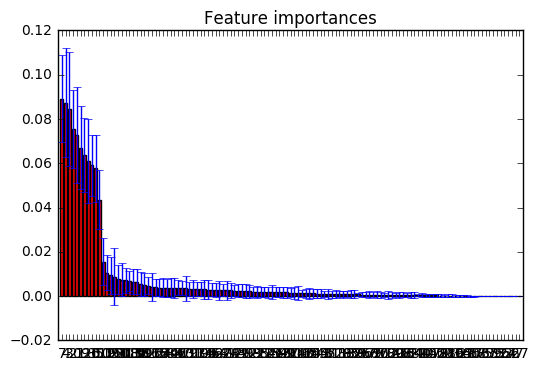

In [48]:
forest = clf
X = dff
y = target
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f), %s" % (f + 1, indices[f], importances[indices[f]], X.columns[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])

In [47]:
cross_val_score(clf, dff, target, scoring='neg_mean_squared_error', n_jobs=-1).mean()

-0.07925716383174726

# YELLOW CARDS IS THE MOST IMPORTANT FEATURES!
# For regressor, we should filter out the ratings that are to different from one another


# TEST CELLS

In [72]:


d = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                  'foo', 'bar', 'foo', 'foo'],
                  'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                  'C' : np.random.randn(8),
                  'D' : np.random.randn(8),
                  'E' : [np.nan,'0','1','0','1','0','1','1'],
                  'F' : [1,2,3,4,5,6,7,8]})
d.set_index('F', inplace=True)

In [73]:
x = []
for c in d['A']:
    x.append(c)
    
x

['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo']